Using transfer learning to train CIFAR-10 dataset on ResNet50 model available in Keras

In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np

try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.13.0


Defining the parameters - batch size and classes

In [2]:
BATCH_SIZE = 32
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Defining some functions that will help in creating visualizations which will be used later

In [3]:
#Matplotlib config
plt.rc('image', cmap = 'gray')
plt.rc('grid', linewidth = 0)
plt.rc('xtick', top = False, bottom = False, labelsize = 'large')
plt.rc('ytick', left = False, right = False, labelsize = 'large')
plt.rc('axes', facecolor='F8F8F8', titlesize = 'large', edgecolor = 'white')
plt.rc('text', color = 'a8151a')
plt.rc('figure', facecolor = 'F0F0F0') #Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

#Utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):
  n = 10
  indexes = np.random.choice(len(predictions), size = n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]

  fig = plt.figure(figsize = (20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]

    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

#Utility to display training and validation curves
def plot_metrics(metric_name, title, ylim = 5):
  plt.title(title)
  plt.ylim(0, ylim)
  plt.plot(history.history[metric_name], color = 'blue', label = metric_name)
  plt.plot(history.history['val_' + metric_name], color = 'green', label = 'val_' + metric_name)

Loading, preprocessing and visualizing the data -
CIFAR-10 dataset has 32 x 32 RGB images belonging to 10 classes. We will load the dataset from Keras. Here we use display_image to view some of the images and their class labels

170498071/170498071 [==============================] - 3s 0us/step


(32, 32, 3)

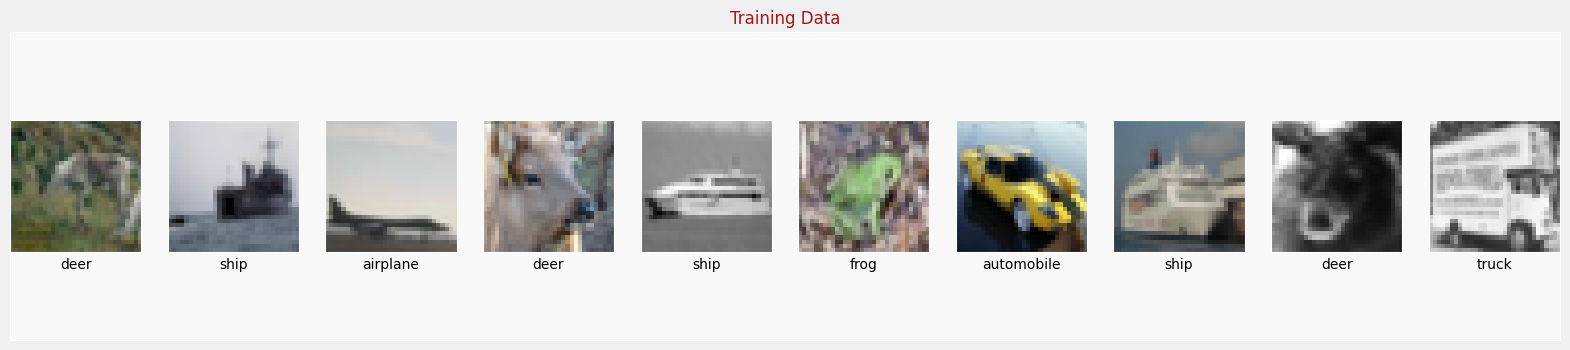

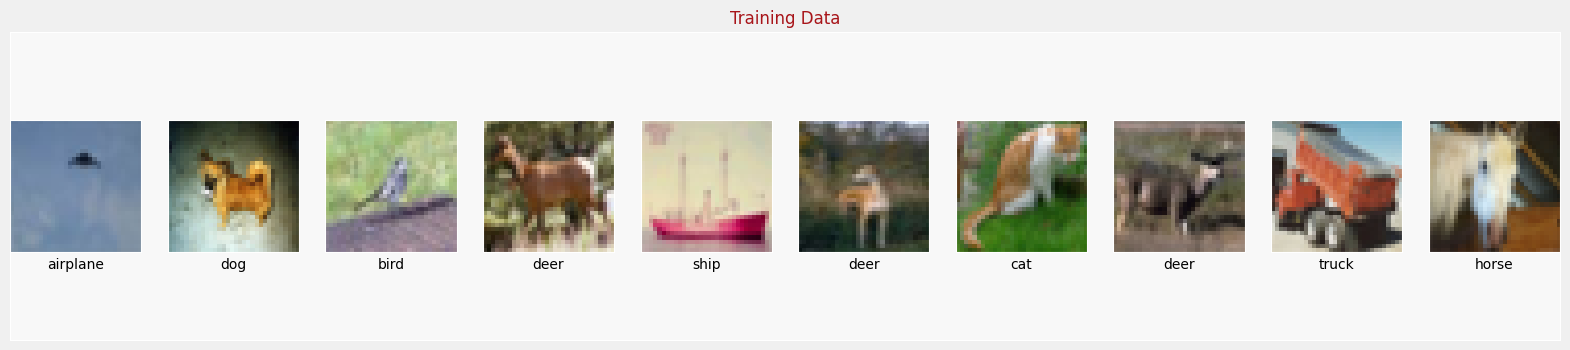

In [4]:
(training_images, training_labels), (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

display_images(training_images, training_labels, training_labels, "Training Data")
display_images(validation_images, validation_labels, validation_labels, "Training Data")
validation_images[0].astype('float32').shape

Performing normalization on the images in the training and the validation set

In [5]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

Now defining the network. Performing transfer learning on ResNet50 available in Keras -
* Loading the pre-trained imagenet weights to the model
* Retaining all layers of ResNet50 along with the final classification layers



In [6]:
from tensorflow.keras.layers import UpSampling2D

# Feature extraction is performed by ResNet50 pretrained on imagenet weights
# Input size is 224 x 224
def feature_extractor(inputs):
  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape = (224, 224, 3),
                                                            include_top = False,
                                                            weights = 'imagenet')(inputs)
  return feature_extractor

# Define final dense layers and subsequent softmax layer for classification
def classifier(inputs):
  x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation = "relu")(x)
  x = tf.keras.layers.Dense(512, activation = "relu")(x)
  x = tf.keras.layers.Dense(10, activation = "softmax", name = "classification")(x)
  return x

# Since the input image size is (32 x 32), first upsample the image by factor of (7 x 7) to transform it to (224 x 224)
# Connect the feature extraction and "classifier" layers to build the model
def final_model(inputs):
  resize = UpSampling2D(size = (7,7))(inputs)
  resnet_feature_extractor = feature_extractor(resize)
  classification_output = classifier(resnet_feature_extractor)
  return classification_output

# Define the model and compile it.
# We use stochastic gradient descent as the optimizer.
# We use sparse categorical cressEntropy as the loss function.
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32, 32, 3))
  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs = inputs, outputs = classification_output)

  model.compile(optimizer = 'SGD', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  return model

model = define_compile_model()
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

Now we train the model and then calculate the loss and accuracy metrics using the model's .evaluate function

In [7]:
EPOCHS = 4
history = model.fit(train_X, training_labels, epochs = EPOCHS, validation_data = (valid_X, validation_labels), batch_size = 64)

loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size = 64)

Epoch 1/4
782/782 [==============================] - 561s 681ms/step - loss: 0.3989 - accuracy: 0.8701 - val_loss: 0.2407 - val_accuracy: 0.9194
Epoch 2/4
782/782 [==============================] - 519s 663ms/step - loss: 0.0995 - accuracy: 0.9673 - val_loss: 0.2132 - val_accuracy: 0.9273
Epoch 3/4
782/782 [==============================] - 532s 680ms/step - loss: 0.0331 - accuracy: 0.9907 - val_loss: 0.1766 - val_accuracy: 0.9467
Epoch 4/4
157/157 [==============================] - 28s 177ms/step - loss: 0.1640 - accuracy: 0.9534


Plotting the loss and accuracy curves, we plot the loss in blue and validation loss in green

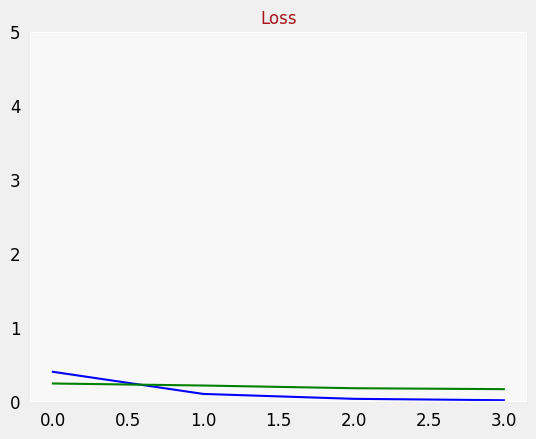

In [12]:
plot_metrics("loss", "Loss")

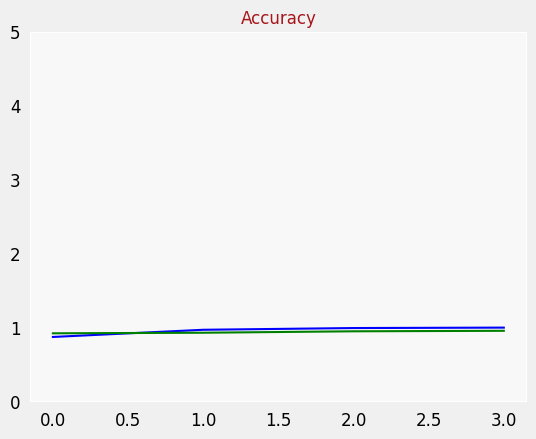

In [11]:
plot_metrics("accuracy", "Accuracy")

Visualizing the predictions on the validation set

157/157 [==============================] - 29s 179ms/step


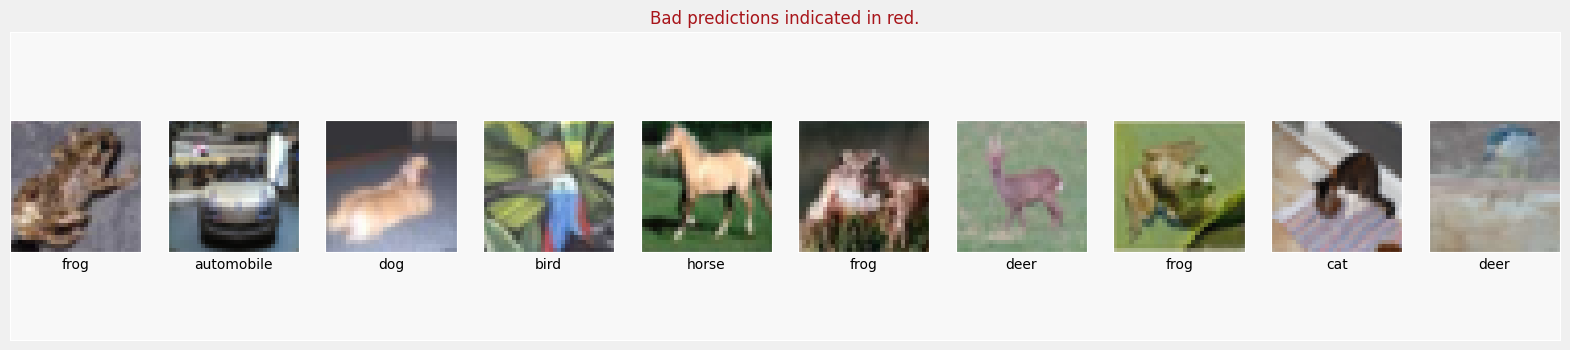

In [9]:
probabilities = model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")